# Project: Dog vs Cat Classification

In [141]:
from pathlib import Path
import os
import torch
from torch import nn

In [142]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [143]:
data_path = Path("data/")
train_path = data_path / "train"
test_path = data_path / "test"

train_path, test_path

(WindowsPath('data/train'), WindowsPath('data/test'))

In [144]:
from PIL import Image
import random
import matplotlib.pyplot as plt
import numpy as np

Text(0.5, 1.0, 'Dog, Shape: (491, 480, 3)')

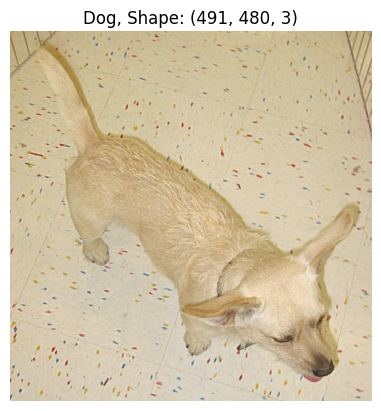

In [145]:
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
image_path_list = list(data_path.glob("*/*/*.jpg"))

random_image_path = random.choice(image_path_list)

image_class = random_image_path.parent.stem

img = Image.open(random_image_path)
img_is_array = np.asarray(img)

plt.imshow(img)
plt.axis(False)
plt.title(f"{image_class}, Shape: {img_is_array.shape}")

In [146]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [147]:
data_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_data_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

In [148]:
transformed_image = data_transform(img)
transformed_image

tensor([[[0.7216, 0.7294, 0.6941,  ..., 0.7255, 0.7176, 0.7059],
         [0.7059, 0.7333, 0.7059,  ..., 0.7333, 0.7333, 0.7216],
         [0.6980, 0.7333, 0.7216,  ..., 0.7412, 0.7490, 0.7451],
         ...,
         [0.8157, 0.7961, 0.8039,  ..., 0.8431, 0.8471, 0.8471],
         [0.7922, 0.7529, 0.7922,  ..., 0.8157, 0.8314, 0.8431],
         [0.7529, 0.8118, 0.8157,  ..., 0.7725, 0.8275, 0.8353]],

        [[0.6353, 0.6667, 0.6118,  ..., 0.6510, 0.6471, 0.6235],
         [0.6157, 0.6667, 0.6314,  ..., 0.6627, 0.6667, 0.6471],
         [0.6039, 0.6706, 0.6510,  ..., 0.6706, 0.6784, 0.6706],
         ...,
         [0.7686, 0.7608, 0.7647,  ..., 0.7686, 0.7882, 0.7922],
         [0.7529, 0.7294, 0.7608,  ..., 0.7373, 0.7647, 0.7882],
         [0.7255, 0.7686, 0.7725,  ..., 0.7451, 0.7765, 0.7843]],

        [[0.4588, 0.4980, 0.4471,  ..., 0.4980, 0.4863, 0.4510],
         [0.4471, 0.5020, 0.4588,  ..., 0.5059, 0.5020, 0.4824],
         [0.4314, 0.5059, 0.4863,  ..., 0.5176, 0.5216, 0.

Text(0.5, 1.0, 'Dog, Shape: torch.Size([3, 64, 64])')

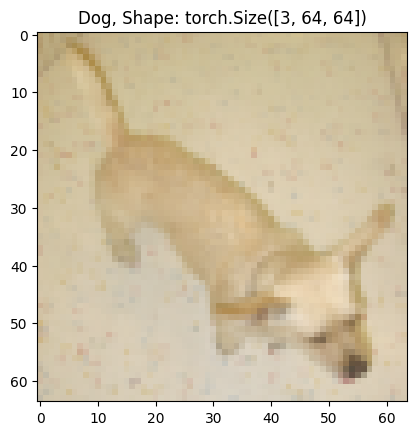

In [149]:
plt.imshow(transformed_image.permute(1, 2, 0))
plt.title(f"{image_class}, Shape: {transformed_image.shape}")

# Loading data using 'ImageFolder'

In [150]:
train_data = datasets.ImageFolder(root=train_path,
                                  transform=data_transform)

test_data = datasets.ImageFolder(root=test_path,
                                 transform=test_data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 4526
     Root location: data\train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 1072
     Root location: data\test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ))

In [151]:
# Get class names as list
class_names = train_data.classes
class_names

['Cat', 'Dog']

In [152]:
# Get class names as dictionary 
class_dict = train_data.class_to_idx
class_dict

{'Cat': 0, 'Dog': 1}

In [153]:
len(train_data), len(test_data)

(4526, 1072)

# Turn loaded images into 'DataLoader'

In [154]:
BATCH_SIZE = 32
NUM_WORKERS = 0

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=NUM_WORKERS,
                             shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x25bb87d3a90>,
 <torch.utils.data.dataloader.DataLoader at 0x25bb87d36d0>)

In [155]:
img_custom, label_custom = next(iter(train_dataloader))

img_custom.shape, label_custom.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [156]:
class DogVsCat(nn.Module):
    def __init__(self, input_shape, hidden_layers, output_shape):
        super().__init__()

        self.conv_block_layer_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_layers,
                      kernel_size=3,
                      padding=1,
                      stride=1),
            nn.BatchNorm2d(num_features=hidden_layers),
            nn.ReLU(),
            #nn.Dropout(p=0.2),
            nn.Conv2d(in_channels=hidden_layers,
                      out_channels=hidden_layers * 2,
                      kernel_size=3,
                      padding=1,
                      stride=1),
            nn.BatchNorm2d(num_features=hidden_layers*2),
            nn.ReLU(),
            #nn.Dropout(p=0.2),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )

        self.conv_block_layer_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_layers*2,
                      out_channels=hidden_layers*2*2,
                      kernel_size=3,
                      padding=1,
                      stride=1),
            nn.BatchNorm2d(num_features=hidden_layers*2*2),
            nn.ReLU(),
            #nn.Dropout(p=0.2),
            nn.Conv2d(in_channels=hidden_layers*2*2,
                      out_channels=hidden_layers*2*2*2,
                      kernel_size=3,
                      padding=1,
                      stride=1),
            nn.BatchNorm2d(num_features=hidden_layers*2*2*2),
            nn.ReLU(),
           # nn.Dropout(p=0.2),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )

        self.classification = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_layers*16*16*8,
                      #out_features=output_shape
                      out_features=128),
            nn.ReLU(),
            nn.Linear(128, output_shape)
        )

    def forward(self, x):
        #print(f"Shape: {x.shape}")
        x = self.conv_block_layer_1(x)
        #print(f"Shape: {x.shape}")
        x = self.conv_block_layer_2(x)
        #print(f"Shape: {x.shape}")
        x = self.classification(x)
        #print(f"Shape: {x.shape}")
        return x
        

In [157]:
model_0 = DogVsCat(input_shape=3, hidden_layers=16, output_shape=1).to(device)
model_0

DogVsCat(
  (conv_block_layer_1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_layer_2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classification): S

In [158]:
# Setup loss function and optimizer
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr=0.001)

loss_fn, optimizer

(BCEWithLogitsLoss(),
 Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     capturable: False
     differentiable: False
     eps: 1e-08
     foreach: None
     fused: None
     lr: 0.001
     maximize: False
     weight_decay: 0
 ))

In [159]:
# Check the correct shape on dummy tensor
dummy_input = torch.randn(32, 3, 64, 64)
output = model_0(dummy_input.to(device))
output

tensor([[0.1610],
        [0.4328],
        [0.4794],
        [0.3408],
        [0.3331],
        [0.2188],
        [0.3335],
        [0.2039],
        [0.2863],
        [0.3370],
        [0.1354],
        [0.5164],
        [0.1836],
        [0.1284],
        [0.0788],
        [0.1380],
        [0.2923],
        [0.2209],
        [0.2550],
        [0.1415],
        [0.4854],
        [0.3693],
        [0.1684],
        [0.3703],
        [0.1148],
        [0.2048],
        [0.1429],
        [0.3778],
        [0.2353],
        [0.5056],
        [0.2779],
        [0.3274]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [160]:
from tqdm import tqdm
import time

In [161]:
epochs = 5

start_time = time.time()

results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []}

for epoch in tqdm(range(epochs)):

    model_0.train()
    train_loss, train_acc = 0, 0
    
    for batch, (X, y) in enumerate(train_dataloader):
        X, y = X.to(device), y.to(device)

        y = y.unsqueeze(dim=1).float()
        
        y_pred = model_0(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        
        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        y_pred_class = (torch.sigmoid(y_pred) > 0.5).float()
        train_acc += (y_pred_class==y).sum().item() / len(y_pred)

    train_loss /= len(train_dataloader)
    train_acc = (train_acc / len(train_dataloader)) * 100
    
    model_0.eval()
    test_loss, test_acc = 0, 0
    
    with torch.inference_mode():
        for batch, (X, y) in enumerate(test_dataloader):
            X, y = X.to(device), y.to(device)

            y = y.unsqueeze(dim=1).float()
        
            test_pred = model_0(X)

            loss = loss_fn(test_pred, y)
            test_loss += loss.item()

            test_pred_class = (torch.sigmoid(test_pred) > 0.5).float()
            test_acc += (test_pred_class==y).sum().item() / len(test_pred)
    
        test_loss /= len(test_dataloader)
        test_acc = (test_acc / len(test_dataloader)) * 100

    print(f"Epoch: {epoch} | Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f} | Test Loss: {test_loss}, Test Accuracy: {test_acc}")

    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)
    


end_time = time.time()
train_time = end_time - start_time

print(f"Total time: {train_time}")

 20%|██        | 1/5 [00:11<00:47, 11.81s/it]

Epoch: 0 | Train Loss: 1.0317, Train Accuracy: 55.72 | Test Loss: 0.642987624687307, Test Accuracy: 64.15441176470588


 40%|████      | 2/5 [00:23<00:35, 11.85s/it]

Epoch: 1 | Train Loss: 0.6333, Train Accuracy: 65.03 | Test Loss: 0.6086100287297193, Test Accuracy: 68.19852941176471


 60%|██████    | 3/5 [00:35<00:23, 11.81s/it]

Epoch: 2 | Train Loss: 0.5767, Train Accuracy: 70.06 | Test Loss: 0.5537607424399432, Test Accuracy: 72.70220588235294


 80%|████████  | 4/5 [00:47<00:11, 11.72s/it]

Epoch: 3 | Train Loss: 0.5527, Train Accuracy: 71.95 | Test Loss: 0.524393073776189, Test Accuracy: 74.35661764705883


100%|██████████| 5/5 [00:58<00:00, 11.73s/it]

Epoch: 4 | Train Loss: 0.5349, Train Accuracy: 73.37 | Test Loss: 0.5337378439657828, Test Accuracy: 71.78308823529412
Total time: 58.65747046470642


# Plot model_0 results

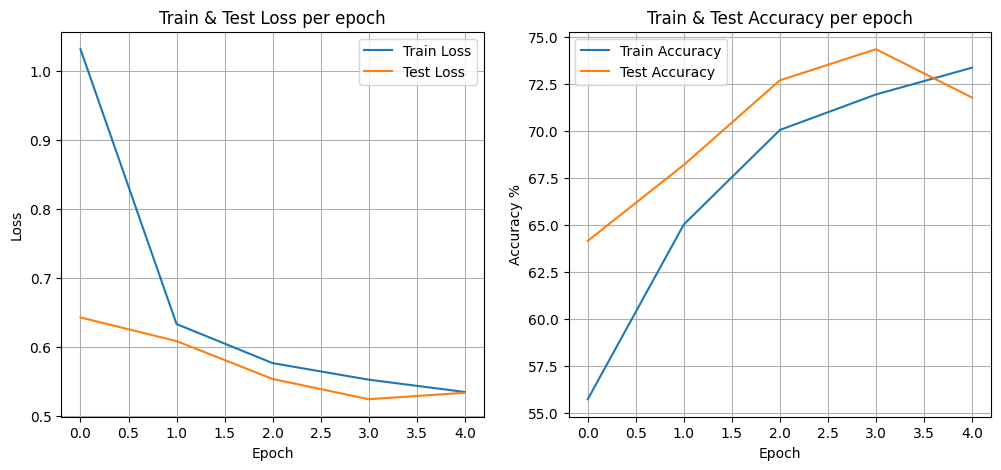

In [162]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(epochs), results["train_loss"], label="Train Loss")
plt.plot(range(epochs), results["test_loss"], label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train & Test Loss per epoch")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(range(epochs), results["train_acc"], label="Train Accuracy")
plt.plot(range(epochs), results["test_acc"], label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy %")
plt.title("Train & Test Accuracy per epoch")
plt.legend()
plt.grid()



In [163]:
print(len(results["train_loss"]), len(results["test_loss"]))
print(len(results["train_acc"]), len(results["test_acc"]))

5 5
5 5


In [164]:
# Build train and test function to make training easier
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim,
               device=device):

    train_loss, correct_preds, total_samples = 0, 0, 0
    model.train()

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        y = y.unsqueeze(dim=1).float()
        
        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        
        optimizer.zero_grad()

        loss.backward()

        optimizer.step()
        
        y_pred_class = (torch.sigmoid(y_pred) > 0.5).float()
        #train_acc += (y_pred_class==y).sum().item() / len(y_pred)
        correct_preds += (y_pred_class == y).sum().item()
        total_samples += y.size(0)

    train_loss /= len(dataloader)
    #train_acc = (train_acc / len(dataloader)) * 100
    train_acc = (correct_preds / total_samples) * 100
    
    return train_loss, train_acc

In [165]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device=device):

    test_loss, correct_preds, total_samples = 0, 0, 0
    model.eval()
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            y = y.unsqueeze(dim=1).float()
        
            test_pred = model(X)

            loss = loss_fn(test_pred, y)
            test_loss += loss.item()

            test_pred_class = (torch.sigmoid(test_pred) > 0.5).float()
            #test_acc += (test_pred_class==y).sum().item() / len(test_pred)
            correct_preds += (test_pred_class == y).sum().item()
            total_samples += y.size(0)
    
    test_loss /= len(dataloader)
    #test_acc = (test_acc / len(dataloader)) * 100
    test_acc = (correct_preds / total_samples) * 100
    return test_loss, test_acc

# Augmentation data

In [166]:
train_data_transform_augmentation = transforms.Compose([
    #transforms.Resize(size=(64, 64)),
    transforms.RandomResizedCrop(size=(64, 64), scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    #transforms.RandomAffine(degrees=15, translate=(1, 1)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31), # used to differentiate the data
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

test_data = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])
train_data_transform_augmentation, test_data

(Compose(
     RandomResizedCrop(size=(64, 64), scale=(0.8, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
     RandomHorizontalFlip(p=0.5)
     RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
     ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=(0.8, 1.2), hue=(-0.1, 0.1))
     TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
     ToTensor()
     Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
 ),
 Compose(
     Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
     ToTensor()
     Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
 ))

In [167]:
train_data_augmentation = datasets.ImageFolder(root=train_path,
                                               transform=train_data_transform_augmentation)
test_data_augmentation = datasets.ImageFolder(root=test_path,
                                              transform=test_data)

train_data_augmentation, test_data_augmentation

(Dataset ImageFolder
     Number of datapoints: 4526
     Root location: data\train
     StandardTransform
 Transform: Compose(
                RandomResizedCrop(size=(64, 64), scale=(0.8, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
                RandomHorizontalFlip(p=0.5)
                RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
                ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=(0.8, 1.2), hue=(-0.1, 0.1))
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
                Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
            ),
 Dataset ImageFolder
     Number of datapoints: 1072
     Root location: data\test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
                Norm

In [168]:
BATCH_SIZE = 32
NUM_WORKERS = 0

train_dataloader_augmentation = DataLoader(dataset=train_data_augmentation,
                                           batch_size=BATCH_SIZE,
                                           num_workers=NUM_WORKERS,
                                           shuffle=True)

test_dataloader_augmentation = DataLoader(dataset=test_data_augmentation,
                                          batch_size=BATCH_SIZE,
                                          num_workers=NUM_WORKERS,
                                          shuffle=False)

train_dataloader_augmentation, test_dataloader_augmentation

(<torch.utils.data.dataloader.DataLoader at 0x25bb80a2d30>,
 <torch.utils.data.dataloader.DataLoader at 0x25bb80a29a0>)

In [169]:
len(class_names)

2

In [170]:
model_1 = DogVsCat(input_shape=3, hidden_layers=8, output_shape=1).to(device)
model_1

DogVsCat(
  (conv_block_layer_1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_layer_2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classification): Sequen

In [171]:
# Setup loss function and optimizer
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.001)
                             #lr=0.00025)
#optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.01, momentum=0.9)
loss_fn, optimizer

(BCEWithLogitsLoss(),
 Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     capturable: False
     differentiable: False
     eps: 1e-08
     foreach: None
     fused: None
     lr: 0.001
     maximize: False
     weight_decay: 0
 ))

In [172]:
# Train model_1 on augmentation data
epochs = 50

start_time = time.time()

results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []}

for epoch in tqdm(range(epochs)):

    train_loss, train_acc = train_step(model=model_1,
               dataloader=train_dataloader_augmentation,
               loss_fn=loss_fn,
               optimizer=optimizer)

    test_loss, test_acc = test_step(model=model_1,
              dataloader=test_dataloader_augmentation,
              loss_fn=loss_fn)

    print(f"Epoch: {epoch} | Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f} | Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}")

    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)
    


end_time = time.time()
train_time = end_time - start_time

print(f"Total time: {train_time}")

  2%|▏         | 1/50 [00:17<14:22, 17.61s/it]

Epoch: 0 | Train Loss: 0.8611, Train Accuracy: 52.70 | Test Loss: 0.6591, Test Accuracy: 61.01


  4%|▍         | 2/50 [00:35<14:08, 17.67s/it]

Epoch: 1 | Train Loss: 0.6759, Train Accuracy: 59.43 | Test Loss: 0.6561, Test Accuracy: 58.58


  6%|▌         | 3/50 [00:52<13:50, 17.67s/it]

Epoch: 2 | Train Loss: 0.6517, Train Accuracy: 62.09 | Test Loss: 0.5924, Test Accuracy: 68.38


  8%|▊         | 4/50 [01:10<13:32, 17.66s/it]

Epoch: 3 | Train Loss: 0.6434, Train Accuracy: 62.57 | Test Loss: 0.5779, Test Accuracy: 70.24


 10%|█         | 5/50 [01:28<13:15, 17.67s/it]

Epoch: 4 | Train Loss: 0.6346, Train Accuracy: 63.32 | Test Loss: 0.5686, Test Accuracy: 69.12


 12%|█▏        | 6/50 [01:45<12:55, 17.63s/it]

Epoch: 5 | Train Loss: 0.6309, Train Accuracy: 63.43 | Test Loss: 0.5529, Test Accuracy: 73.41


 14%|█▍        | 7/50 [02:03<12:36, 17.59s/it]

Epoch: 6 | Train Loss: 0.6248, Train Accuracy: 64.23 | Test Loss: 0.5311, Test Accuracy: 73.79


 16%|█▌        | 8/50 [02:21<12:19, 17.61s/it]

Epoch: 7 | Train Loss: 0.6140, Train Accuracy: 66.37 | Test Loss: 0.5516, Test Accuracy: 70.90


 18%|█▊        | 9/50 [02:38<12:06, 17.71s/it]

Epoch: 8 | Train Loss: 0.6063, Train Accuracy: 66.00 | Test Loss: 0.5770, Test Accuracy: 70.15


 20%|██        | 10/50 [02:57<11:54, 17.87s/it]

Epoch: 9 | Train Loss: 0.6066, Train Accuracy: 66.53 | Test Loss: 0.5138, Test Accuracy: 74.63


 22%|██▏       | 11/50 [03:14<11:33, 17.79s/it]

Epoch: 10 | Train Loss: 0.5979, Train Accuracy: 67.28 | Test Loss: 0.5455, Test Accuracy: 71.36


 24%|██▍       | 12/50 [03:32<11:15, 17.77s/it]

Epoch: 11 | Train Loss: 0.5825, Train Accuracy: 68.23 | Test Loss: 0.5172, Test Accuracy: 74.16


 26%|██▌       | 13/50 [03:50<10:56, 17.74s/it]

Epoch: 12 | Train Loss: 0.5777, Train Accuracy: 68.67 | Test Loss: 0.4953, Test Accuracy: 76.31


 28%|██▊       | 14/50 [04:07<10:36, 17.69s/it]

Epoch: 13 | Train Loss: 0.5717, Train Accuracy: 69.60 | Test Loss: 0.4899, Test Accuracy: 76.12


 30%|███       | 15/50 [04:25<10:21, 17.75s/it]

Epoch: 14 | Train Loss: 0.5716, Train Accuracy: 69.42 | Test Loss: 0.4577, Test Accuracy: 78.17


 32%|███▏      | 16/50 [04:43<10:01, 17.70s/it]

Epoch: 15 | Train Loss: 0.5620, Train Accuracy: 69.97 | Test Loss: 0.4878, Test Accuracy: 77.24


 34%|███▍      | 17/50 [05:00<09:43, 17.68s/it]

Epoch: 16 | Train Loss: 0.5553, Train Accuracy: 70.70 | Test Loss: 0.4519, Test Accuracy: 78.54


 36%|███▌      | 18/50 [05:18<09:22, 17.59s/it]

Epoch: 17 | Train Loss: 0.5449, Train Accuracy: 71.21 | Test Loss: 0.4522, Test Accuracy: 77.71


 38%|███▊      | 19/50 [05:35<09:03, 17.53s/it]

Epoch: 18 | Train Loss: 0.5444, Train Accuracy: 71.52 | Test Loss: 0.4582, Test Accuracy: 77.71


 40%|████      | 20/50 [05:53<08:46, 17.54s/it]

Epoch: 19 | Train Loss: 0.5230, Train Accuracy: 72.36 | Test Loss: 0.4301, Test Accuracy: 80.04


 42%|████▏     | 21/50 [06:10<08:29, 17.56s/it]

Epoch: 20 | Train Loss: 0.5388, Train Accuracy: 71.94 | Test Loss: 0.4304, Test Accuracy: 80.22


 44%|████▍     | 22/50 [06:28<08:15, 17.68s/it]

Epoch: 21 | Train Loss: 0.5232, Train Accuracy: 72.65 | Test Loss: 0.4605, Test Accuracy: 78.92


 46%|████▌     | 23/50 [06:46<07:55, 17.61s/it]

Epoch: 22 | Train Loss: 0.5020, Train Accuracy: 74.94 | Test Loss: 0.4967, Test Accuracy: 77.80


 48%|████▊     | 24/50 [07:04<07:41, 17.74s/it]

Epoch: 23 | Train Loss: 0.5088, Train Accuracy: 73.27 | Test Loss: 0.5289, Test Accuracy: 73.60


 50%|█████     | 25/50 [07:21<07:22, 17.72s/it]

Epoch: 24 | Train Loss: 0.5054, Train Accuracy: 74.61 | Test Loss: 0.4247, Test Accuracy: 80.88


 52%|█████▏    | 26/50 [07:39<07:03, 17.65s/it]

Epoch: 25 | Train Loss: 0.5008, Train Accuracy: 74.55 | Test Loss: 0.4593, Test Accuracy: 77.05


 54%|█████▍    | 27/50 [07:56<06:44, 17.60s/it]

Epoch: 26 | Train Loss: 0.5126, Train Accuracy: 73.64 | Test Loss: 0.4198, Test Accuracy: 79.29


 56%|█████▌    | 28/50 [08:14<06:28, 17.64s/it]

Epoch: 27 | Train Loss: 0.4858, Train Accuracy: 75.36 | Test Loss: 0.3781, Test Accuracy: 82.56


 58%|█████▊    | 29/50 [08:33<06:17, 17.97s/it]

Epoch: 28 | Train Loss: 0.4927, Train Accuracy: 75.41 | Test Loss: 0.4830, Test Accuracy: 79.94


 60%|██████    | 30/50 [08:51<06:03, 18.16s/it]

Epoch: 29 | Train Loss: 0.4935, Train Accuracy: 74.72 | Test Loss: 0.6209, Test Accuracy: 73.13


 62%|██████▏   | 31/50 [09:10<05:44, 18.12s/it]

Epoch: 30 | Train Loss: 0.4923, Train Accuracy: 75.01 | Test Loss: 0.3855, Test Accuracy: 82.18


 64%|██████▍   | 32/50 [09:29<05:30, 18.38s/it]

Epoch: 31 | Train Loss: 0.4871, Train Accuracy: 75.87 | Test Loss: 0.3900, Test Accuracy: 81.53


 66%|██████▌   | 33/50 [09:46<05:07, 18.11s/it]

Epoch: 32 | Train Loss: 0.4827, Train Accuracy: 75.65 | Test Loss: 0.3824, Test Accuracy: 82.37


 68%|██████▊   | 34/50 [10:08<05:10, 19.39s/it]

Epoch: 33 | Train Loss: 0.4775, Train Accuracy: 75.92 | Test Loss: 0.4135, Test Accuracy: 80.88


 70%|███████   | 35/50 [10:29<04:55, 19.69s/it]

Epoch: 34 | Train Loss: 0.4715, Train Accuracy: 76.29 | Test Loss: 0.4051, Test Accuracy: 81.53


 72%|███████▏  | 36/50 [10:48<04:33, 19.54s/it]

Epoch: 35 | Train Loss: 0.4626, Train Accuracy: 77.55 | Test Loss: 0.5456, Test Accuracy: 77.52


 74%|███████▍  | 37/50 [11:07<04:11, 19.37s/it]

Epoch: 36 | Train Loss: 0.4852, Train Accuracy: 75.94 | Test Loss: 0.3863, Test Accuracy: 82.74


 76%|███████▌  | 38/50 [11:26<03:52, 19.40s/it]

Epoch: 37 | Train Loss: 0.4632, Train Accuracy: 76.60 | Test Loss: 0.4566, Test Accuracy: 79.29


 78%|███████▊  | 39/50 [11:45<03:31, 19.27s/it]

Epoch: 38 | Train Loss: 0.4652, Train Accuracy: 77.24 | Test Loss: 0.3808, Test Accuracy: 82.56


 80%|████████  | 40/50 [12:04<03:10, 19.06s/it]

Epoch: 39 | Train Loss: 0.4591, Train Accuracy: 77.79 | Test Loss: 0.3938, Test Accuracy: 83.02


 82%|████████▏ | 41/50 [12:22<02:50, 18.91s/it]

Epoch: 40 | Train Loss: 0.4532, Train Accuracy: 78.30 | Test Loss: 0.3735, Test Accuracy: 82.93


 84%|████████▍ | 42/50 [12:42<02:31, 18.97s/it]

Epoch: 41 | Train Loss: 0.4556, Train Accuracy: 77.75 | Test Loss: 0.3786, Test Accuracy: 81.72


 86%|████████▌ | 43/50 [13:00<02:11, 18.81s/it]

Epoch: 42 | Train Loss: 0.4513, Train Accuracy: 77.42 | Test Loss: 0.3622, Test Accuracy: 83.96


 88%|████████▊ | 44/50 [13:19<01:52, 18.79s/it]

Epoch: 43 | Train Loss: 0.4398, Train Accuracy: 78.44 | Test Loss: 0.3813, Test Accuracy: 83.12


 90%|█████████ | 45/50 [13:38<01:34, 18.85s/it]

Epoch: 44 | Train Loss: 0.4506, Train Accuracy: 78.55 | Test Loss: 0.4144, Test Accuracy: 82.37


 92%|█████████▏| 46/50 [13:56<01:15, 18.78s/it]

Epoch: 45 | Train Loss: 0.4479, Train Accuracy: 77.29 | Test Loss: 0.3770, Test Accuracy: 81.62


 94%|█████████▍| 47/50 [14:20<01:00, 20.22s/it]

Epoch: 46 | Train Loss: 0.4404, Train Accuracy: 78.17 | Test Loss: 0.4175, Test Accuracy: 82.28


 96%|█████████▌| 48/50 [14:41<00:41, 20.51s/it]

Epoch: 47 | Train Loss: 0.4379, Train Accuracy: 78.72 | Test Loss: 0.3757, Test Accuracy: 84.05


 98%|█████████▊| 49/50 [15:02<00:20, 20.63s/it]

Epoch: 48 | Train Loss: 0.4341, Train Accuracy: 79.50 | Test Loss: 0.3894, Test Accuracy: 83.30


100%|██████████| 50/50 [15:24<00:00, 18.49s/it]

Epoch: 49 | Train Loss: 0.4314, Train Accuracy: 79.05 | Test Loss: 0.3786, Test Accuracy: 83.30
Total time: 924.4866991043091


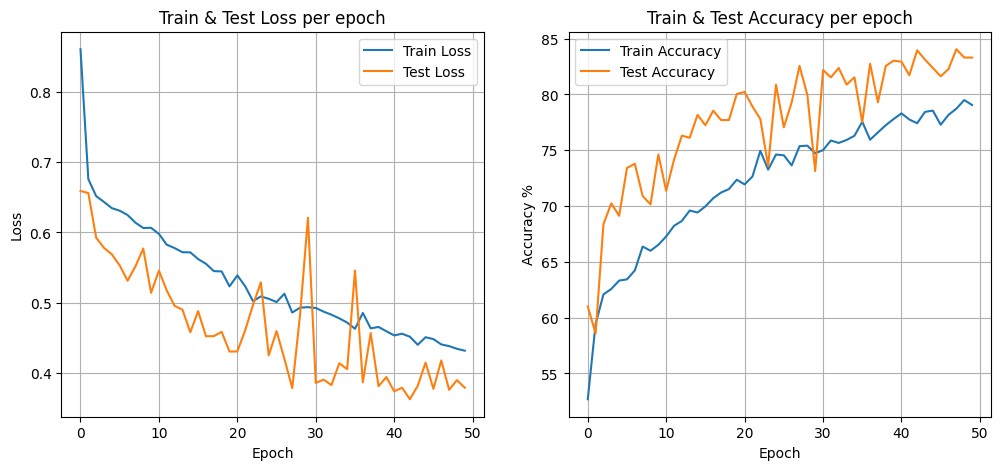

In [173]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(epochs), results["train_loss"], label="Train Loss")
plt.plot(range(epochs), results["test_loss"], label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train & Test Loss per epoch")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(range(epochs), results["train_acc"], label="Train Accuracy")
plt.plot(range(epochs), results["test_acc"], label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy %")
plt.title("Train & Test Accuracy per epoch")
plt.legend()
plt.grid()

In [174]:
from torch.utils.data import Subset

In [175]:
train_100_images = Subset(train_data_augmentation, range(100))
test_20_images = Subset(test_data_augmentation, range(20))

len(train_100_images), len(test_20_images)

(100, 20)